In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns

import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

## The Network

In [2]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [3]:
# hyperameters of the model
# Peptide [batch_size, input_channels, input_height, input_width] > [batch_size, 1, 10, 12]
peptide_input_channels = 1
peptide_input_height = 10
peptide_input_width = 12

# Peptide [batch_size, input_channels, input_height, input_width] > [batch_size, 1, 34, 12]
hla_input_channels = 1
hla_input_height = 34
hla_input_width = 12

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Self-attention models
        self.peptide_attention = nn.MultiheadAttention(embed_dim=12,num_heads=1,dropout=0.4)
        self.HLA_atttention = nn.MultiheadAttention(embed_dim=12,num_heads=1,dropout=0.4)


        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(15,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_HLA = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Denselayer
        self.L_in = Linear(in_features=256,
                            out_features=128)
        
        self.drop_out = nn.Dropout(p=0.2)
        self.L_out = Linear(in_features=128,
                            out_features=2,
                            bias=False)



        # Batch normilzation
        self.batch_norm_1 = BatchNorm1d(264,track_running_stats=False)


        # Denselayer
        # self.L_in = Linear(in_features=160, # 161 if bingding score
        #                     out_features=264)
        # self.drop_out = nn.Dropout(p=0.4)
        self.L_out = Linear(in_features=160,
                            out_features=2,
                            bias=False)

    def forward(self, peptide, HLA, binding_score=None): # x.size() = [batch, channel, height, width]
        
        # Context embedding of peptides and HLA
        context_embedded_peptide, attn_weights_peptide = self.peptide_attention(peptide,peptide,peptide)
        context_embedded_hla, attn_weights_HLA = self.HLA_atttention(HLA,HLA,HLA)
        context_embedded_peptide = context_embedded_peptide.reshape(context_embedded_peptide.shape[0],1,context_embedded_peptide.shape[1],context_embedded_peptide.shape[2])
        context_embedded_hla = context_embedded_hla.reshape(context_embedded_hla.shape[0],1,context_embedded_hla.shape[1],context_embedded_hla.shape[2])

        # Encoding the peptide
        peptide = self.conv1_peptide(context_embedded_peptide)
        # peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        HLA = self.conv1_HLA(context_embedded_hla)
        # HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        # Combining the output
        combined_input = torch.cat((peptide, HLA), 1)
        # x = self.L_in(combined_input)
        # x = self.drop_out(x)
        # x = relu(x)
        x = self.L_out(combined_input)
        x = nn.ReLU()(x)
        return softmax(x, dim=1)
        


net = Net()
net.apply(initialize_weights)
print(net)

Net(
  (peptide_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
  )
  (HLA_atttention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
  )
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(15, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilatio

In [4]:
peptide_random = np.random.normal(0,1, (10, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random)
output

tensor([[0.0641, 0.9359],
        [0.5321, 0.4679],
        [0.4195, 0.5805],
        [0.1681, 0.8319],
        [0.1258, 0.8742],
        [0.2911, 0.7089],
        [0.3341, 0.6659],
        [0.4126, 0.5874],
        [0.1569, 0.8431],
        [0.2245, 0.7755]], grad_fn=<SoftmaxBackward0>)

## Functions for loading data

In [5]:
def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        binding_score = row['binding_score']


        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Plotting functions

In [6]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')
    plt.show()

def calculate_avg_val_performance(K, N, lst_val_acc, lst_val_lab, lst_val_pred):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((K,5))
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

def k_fold_confusion_matrix(K, lst_val_acc, lst_val_lab, lst_val_pred):
    """Plot the overall confusion matrix for 5 fold CV

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
    """
    all_labels = []
    all_predictions = []
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        all_labels.extend(lst_val_lab[i][best_epoch_model])
        all_predictions.extend(lst_val_pred[i][best_epoch_model])

    fig = plt.figure(figsize=(10,6))
    plt.title("Confusion matrix of best epoch for validation performance")
    conf_mat = confusion_matrix(all_labels,all_predictions)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def violin_best_fold(res_mtrx, lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    """For the best fold, find the best epoch, and plot the violin plot

    Args:
        res_mtrx (matrix): result matrix from calculate_avg_performance
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        lst_val_prob (list of lists): list of lists containing validation probabilities for each fold
    """
    best_fold = np.argmax(res_mtrx[:,2])
    best_epoch_model = np.argmax(lst_val_acc[best_fold])
    labels_best_epoch = lst_val_lab[best_fold][best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_fold][best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_fold][best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()


def violin_prbabilities(best_fold,lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    """For the best fold, find the best epoch, and plot the violin plot

    Args:
        res_mtrx (matrix): result matrix from calculate_avg_performance
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        lst_val_prob (list of lists): list of lists containing validation probabilities for each fold
    """
    best_fold = best_fold
    best_epoch_model = np.argmax(lst_val_acc[best_fold])
    labels_best_epoch = lst_val_lab[best_fold][best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_fold][best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_fold][best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()


## Functions for training the models

In [7]:
def validation(model,device,valid_loaders,train_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long()
            train_binding_scores = binding_score_train_loader[i]
            outputs = model(train_peptides,train_HLA) # train_binding_scores
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.numpy().tolist()
            all_train_targets += train_labels.numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        all_probabilities_val = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j]
            val_HLA = HLA_val_loader[j]
            val_labels = label_val_loader[j].long()
            val_binding_scores = binding_score_val_loader[j]
            outputs = model(val_peptides,val_HLA) # val_binding_scores
            probability,predicted_labels =  torch.max(outputs, 1)
            all_predicted_val_labels += predicted_labels.numpy().tolist()
            all_val_targets += val_labels.numpy().tolist()
            all_probabilities_val += probability.numpy().tolist()


    return all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val


def create_data_loader_from_numpy_array(data,batch_size):
    data = Variable(torch.from_numpy(data))
    return list(DataLoader(data,batch_size=batch_size))


def find_low_confidence_predictions(model,device,train_loaders, threshold):
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    # Peptides
    high_confidence_peptide_loader = []
    low_confidence_peptide_loader = []
    # HLA's
    high_confidence_HLA_loader = []
    low_confidence_HLA_loader = []
    #  Labels
    high_confidence_labels_loader = []
    low_confidence_labels_loader = []

    #  Binding scores
    high_confidence_binding_scores_loader = []
    low_confidence_binding_scores_loader = []

    # Batch size
    batch_size = 100

    model.eval()
    with torch.no_grad():
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long()
            train_binding_scores = binding_score_train_loader[i]

            # print(train_peptides.shape,train_HLA.shape,train_labels.shape,train_binding_scores.shape)

            outputs = model(train_peptides,train_HLA) # train_binding_scores
            probability,predicted_labels =  torch.max(outputs, 1)
            probability_indexes = probability <= threshold
            # Peptides
            low_confidence_peptide_loader.append(train_peptides[probability_indexes].numpy())
            high_confidence_peptide_loader.append(train_peptides[~probability_indexes].numpy())

            # HLAs
            low_confidence_HLA_loader.append(train_HLA[probability_indexes].numpy())
            high_confidence_HLA_loader.append(train_HLA[~probability_indexes].numpy())

            # Labels
            low_confidence_labels_loader.append(train_labels[probability_indexes].numpy())
            high_confidence_labels_loader.append(train_labels[~probability_indexes].numpy())

            # Binding scores
            low_confidence_binding_scores_loader.append(train_binding_scores[probability_indexes].numpy())
            high_confidence_binding_scores_loader.append(train_binding_scores[~probability_indexes].numpy())
    
    high_confidence_peptide_loader = np.concatenate(high_confidence_peptide_loader).astype('float32')
    low_confidence_peptide_loader = np.concatenate(low_confidence_peptide_loader).astype('float32')

    high_confidence_HLA_loader = np.concatenate(high_confidence_HLA_loader).astype('float32')
    low_confidence_HLA_loader = np.concatenate(low_confidence_HLA_loader).astype('float32')

    high_confidence_binding_scores_loader = np.concatenate(high_confidence_binding_scores_loader)
    low_confidence_binding_scores_loader = np.concatenate(low_confidence_binding_scores_loader)

    high_confidence_labels_loader = np.concatenate(high_confidence_labels_loader)
    low_confidence_labels_loader = np.concatenate(low_confidence_labels_loader)

    high_confidence_peptide_loader = create_data_loader_from_numpy_array(high_confidence_peptide_loader,batch_size)
    low_confidence_peptide_loader = create_data_loader_from_numpy_array(low_confidence_peptide_loader,batch_size)

    high_confidence_HLA_loader = create_data_loader_from_numpy_array(high_confidence_HLA_loader,batch_size)
    low_confidence_HLA_loader = create_data_loader_from_numpy_array(low_confidence_HLA_loader,batch_size)

    high_confidence_binding_scores_loader = create_data_loader_from_numpy_array(high_confidence_binding_scores_loader,batch_size)
    low_confidence_binding_scores_loader = create_data_loader_from_numpy_array(low_confidence_binding_scores_loader,batch_size)
    high_confidence_labels_loader = create_data_loader_from_numpy_array(high_confidence_labels_loader,batch_size)
    low_confidence_labels_loader = create_data_loader_from_numpy_array(low_confidence_labels_loader,batch_size)


    return [high_confidence_peptide_loader,high_confidence_HLA_loader,high_confidence_labels_loader,high_confidence_binding_scores_loader],[low_confidence_peptide_loader,low_confidence_HLA_loader,low_confidence_labels_loader,low_confidence_binding_scores_loader]

def train(model, device, epochs, train_loaders, valid_loaders):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

    # Early stopping
    the_last_loss = 100
    patience = 100
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []
    all_val_probabilities_pr_epoch = []
    losses = []

    train_accuracies = []
    val_accuracies = []

    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    
    print("Number of observations in training",np.sum([x.shape[0] for x in HLA_train_loader]))
    

    
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index]
            train_HLA = HLA_train_loader[train_batch_index]
            train_labels = label_train_loader[train_batch_index].long()
            train_binding_scores = binding_score_train_loader[train_batch_index]
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA) # train_binding_scores
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val = validation(model,device,valid_loaders,train_loaders)
    
        # Calculating the accuracies
        train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
        val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
        # Saving the predicitons for further validation
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_predicted_val_labels)
        all_val_probabilities_pr_epoch.append(all_probabilities_val)

        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch, losses[-1], train_accuracies[-1], val_accuracies[-1]))

        # Early stopping
        the_current_loss = val_accuracies[-1]
        the_last_loss = 0 if len(val_accuracies) < 2 else val_accuracies[-2]

        # print('The current valdiation loss:', the_current_loss)

        if the_current_loss < the_last_loss:
            trigger_times += 1
            # print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch)
                return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

        else:
            # print('trigger times: 0')
            trigger_times = 0

    return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)


Device state: cpu


## Encoding entire data set

In [8]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding_w_parts.csv")
all_data = all_data.sample(frac=1, random_state=0).reset_index(drop=True)

all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

In [9]:
def plot_confidence_pca_predictions(train_loaders, model, tested_subjects):
    from sklearn.decomposition import PCA
    print(np.sum(tested_subjects.isna()))
    print()
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    probabilities = []
    peptides = []
    with torch.no_grad():
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long()
            train_binding_scores = binding_score_train_loader[i]
            outputs = model(train_peptides,train_HLA) # train_binding_scores
            probability,predicted_labels =  torch.max(outputs, 1)
            probabilities += probability
            peptides += peptide_train_loader[i].numpy().tolist()
    
    peptides = np.array(peptides).reshape(len(peptides),-1)
    probabilities = np.array(probabilities)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(peptides)

    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    
    principalDf["probabilities"] = probabilities
    principalDf["tested_subjects"] = tested_subjects.to_numpy()
    principalDf["threshold"] = principalDf["probabilities"] > 0.9
    finalDf = pd.concat([principalDf, tested_subjects], axis = 1)
    fig = plt.figure(figsize=(12,8))
    sns.scatterplot(data=principalDf,x="PC1",y="PC2",size="tested_subjects",hue="threshold")
    plt.show()

    fig = plt.figure(figsize=(12,8))
    sns.scatterplot(data=principalDf,x="tested_subjects",y="threshold")
    plt.show()


## 5-fold cross-validation loop

the val and train parts
[0, 1] [2, 3, 4, 5, 6, 7, 8, 9]
Number of observations in training 6114
Epoch  0 : Train Loss 0.695950 , Train acc 0.583088, Valid acc 0.586495
Epoch 10 : Train Loss 0.592764 , Train acc 0.701995, Valid acc 0.702894
Epoch 20 : Train Loss 0.580856 , Train acc 0.713445, Valid acc 0.693248
Epoch 30 : Train Loss 0.575073 , Train acc 0.717043, Valid acc 0.691961
Epoch 40 : Train Loss 0.572547 , Train acc 0.724076, Valid acc 0.701608
Epoch 50 : Train Loss 0.568656 , Train acc 0.731109, Valid acc 0.702894


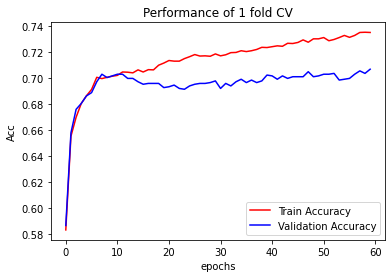

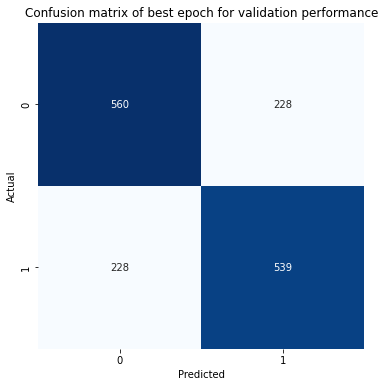

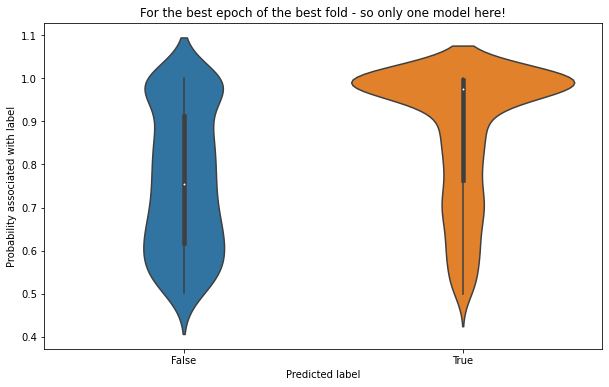

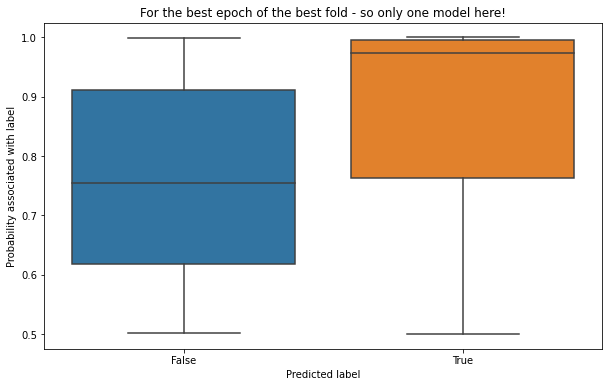

0



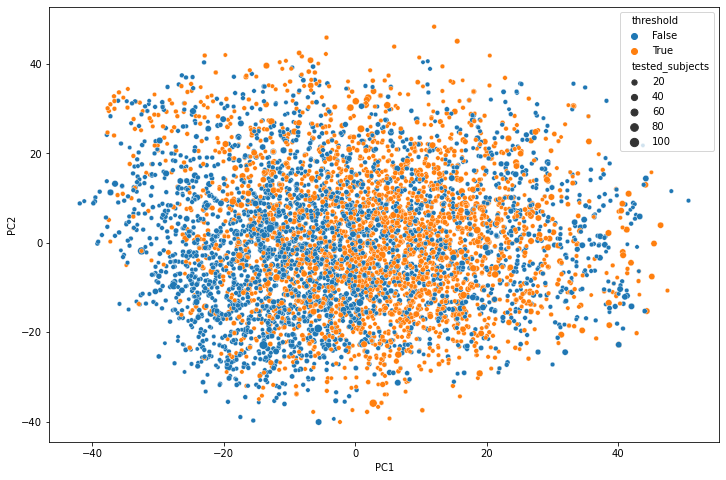

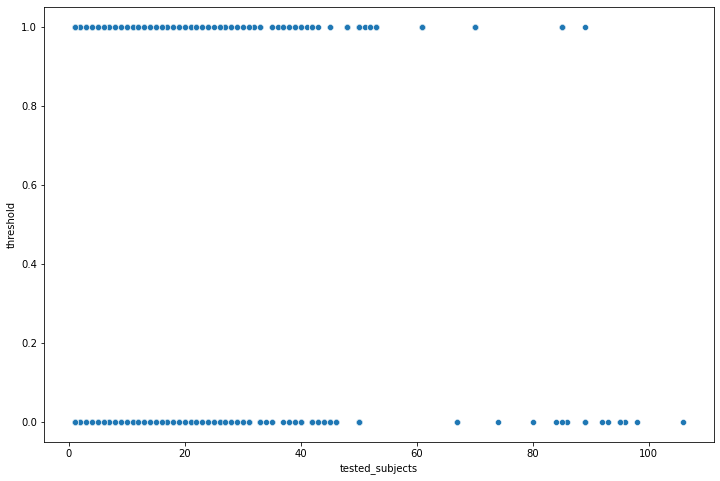

the val and train parts
[2, 3] [0, 1, 4, 5, 6, 7, 8, 9]
Number of observations in training 6127
Epoch  0 : Train Loss 0.683504 , Train acc 0.624286, Valid acc 0.628405
Epoch 10 : Train Loss 0.594015 , Train acc 0.684511, Valid acc 0.684825
Epoch 20 : Train Loss 0.586769 , Train acc 0.690713, Valid acc 0.676394
Epoch 30 : Train Loss 0.581789 , Train acc 0.701485, Valid acc 0.678340
Epoch 40 : Train Loss 0.576307 , Train acc 0.715195, Valid acc 0.686770
Epoch 50 : Train Loss 0.572298 , Train acc 0.723029, Valid acc 0.698444


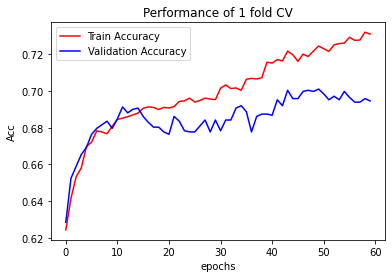

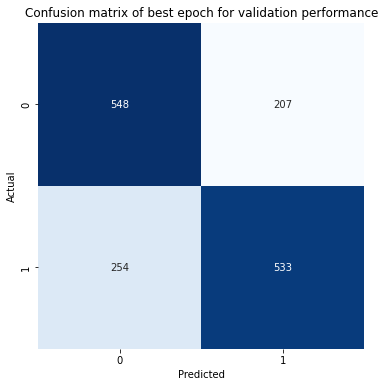

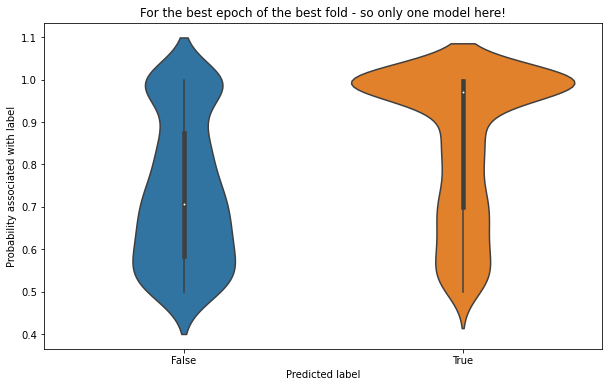

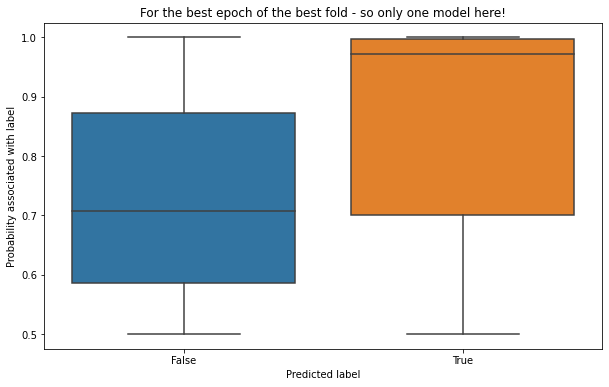

0



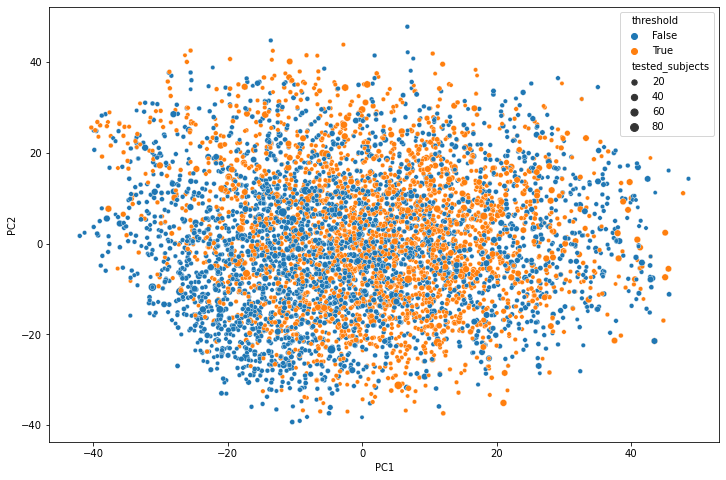

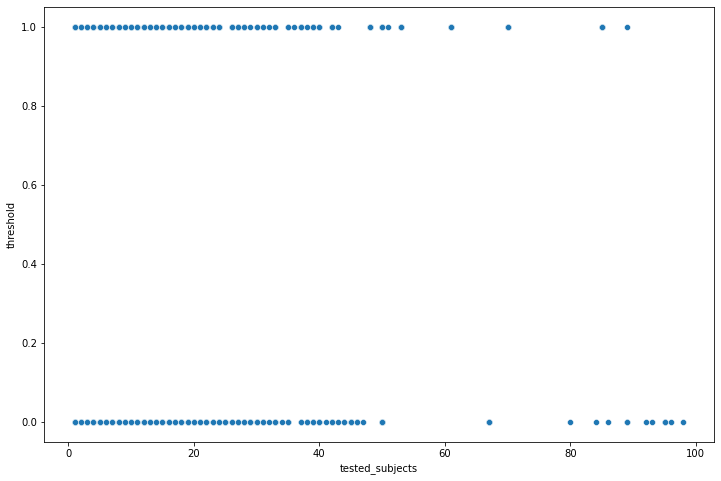

the val and train parts
[4, 5] [0, 1, 2, 3, 6, 7, 8, 9]
Number of observations in training 6151
Epoch  0 : Train Loss 0.697728 , Train acc 0.577955, Valid acc 0.575099
Epoch 10 : Train Loss 0.598512 , Train acc 0.685417, Valid acc 0.675231
Epoch 20 : Train Loss 0.587162 , Train acc 0.703625, Valid acc 0.694993
Epoch 30 : Train Loss 0.581067 , Train acc 0.709478, Valid acc 0.702899
Epoch 40 : Train Loss 0.577036 , Train acc 0.715331, Valid acc 0.700922
Epoch 50 : Train Loss 0.572853 , Train acc 0.725573, Valid acc 0.702899


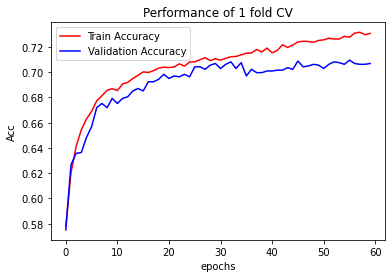

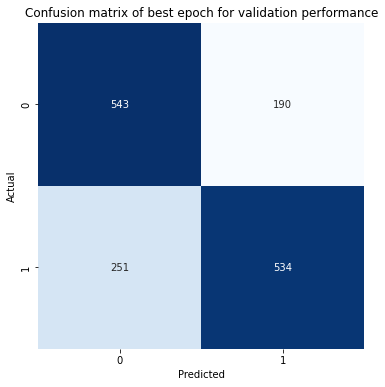

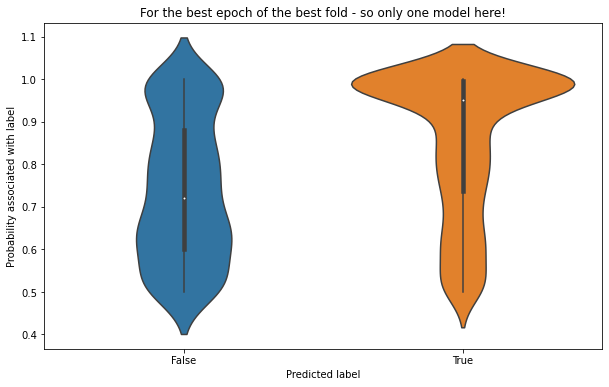

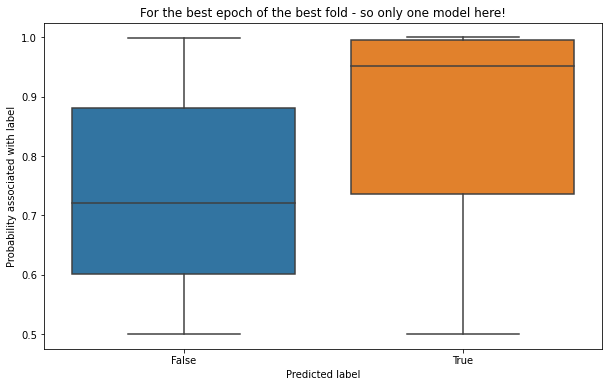

0



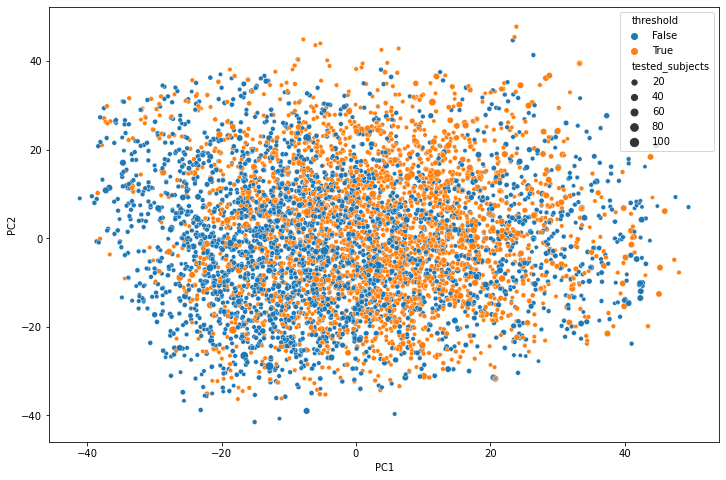

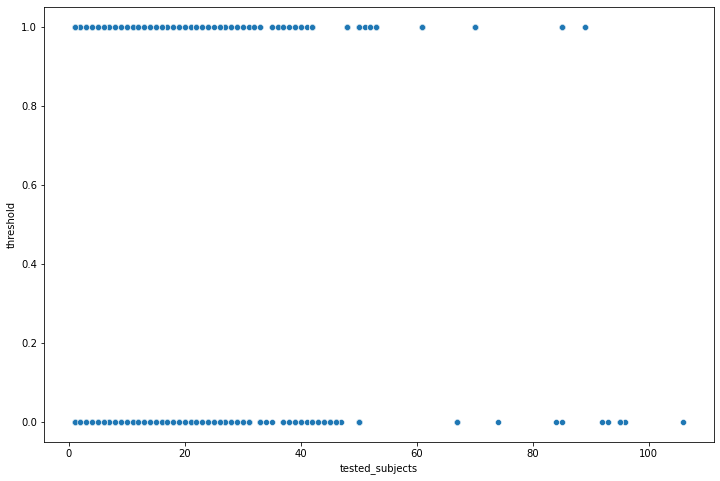

the val and train parts
[6, 7] [0, 1, 2, 3, 4, 5, 8, 9]
Number of observations in training 6153
Epoch  0 : Train Loss 0.700782 , Train acc 0.599707, Valid acc 0.589710
Epoch 10 : Train Loss 0.595962 , Train acc 0.688770, Valid acc 0.661609
Epoch 20 : Train Loss 0.581916 , Train acc 0.703234, Valid acc 0.667546
Epoch 30 : Train Loss 0.574910 , Train acc 0.716073, Valid acc 0.685356
Epoch 40 : Train Loss 0.571717 , Train acc 0.725662, Valid acc 0.682058
Epoch 50 : Train Loss 0.567025 , Train acc 0.737039, Valid acc 0.693931


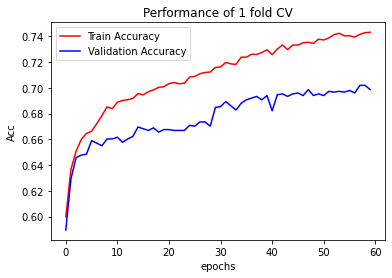

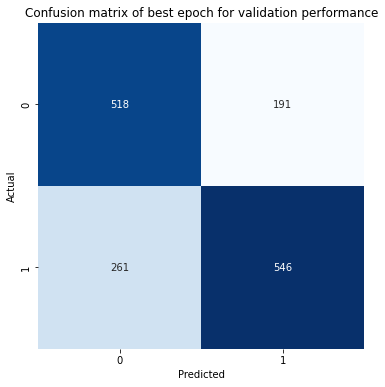

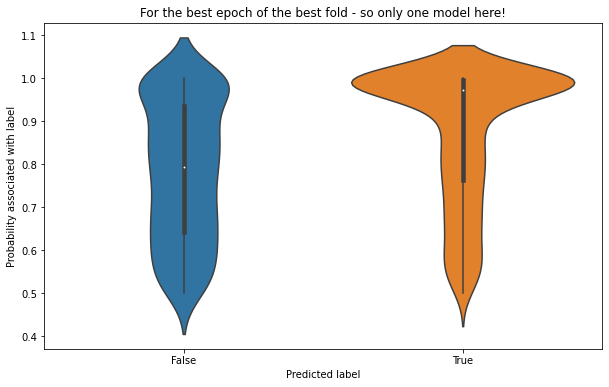

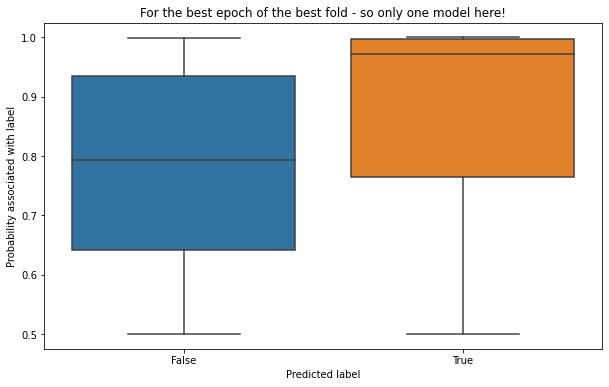

0



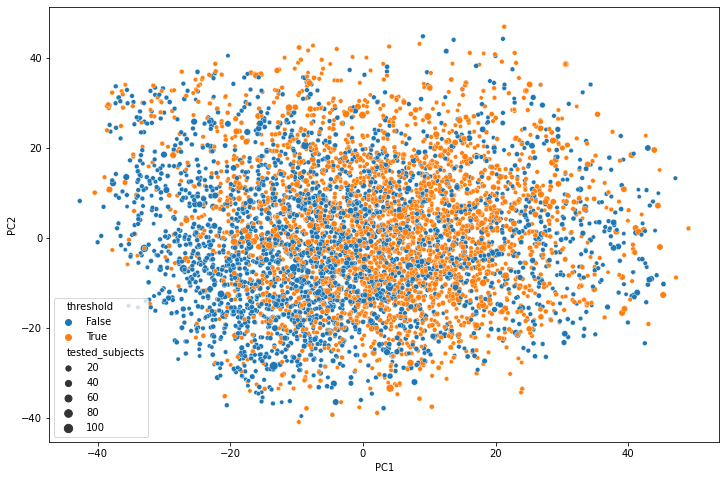

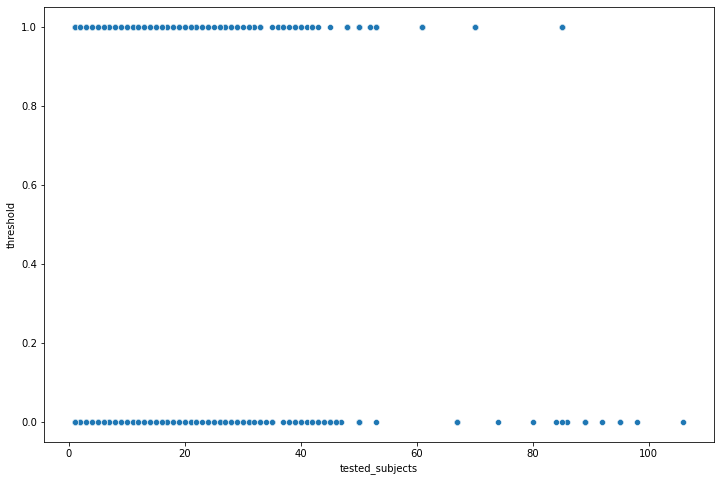

the val and train parts
[8, 9] [0, 1, 2, 3, 4, 5, 6, 7]
Number of observations in training 6131
Epoch  0 : Train Loss 0.701206 , Train acc 0.502365, Valid acc 0.522107
Epoch 10 : Train Loss 0.595870 , Train acc 0.682760, Valid acc 0.681404
Epoch 20 : Train Loss 0.583193 , Train acc 0.702006, Valid acc 0.692458
Epoch 30 : Train Loss 0.576013 , Train acc 0.714892, Valid acc 0.689857
Epoch 40 : Train Loss 0.573838 , Train acc 0.728103, Valid acc 0.700260
Epoch 50 : Train Loss 0.569663 , Train acc 0.732181, Valid acc 0.698960


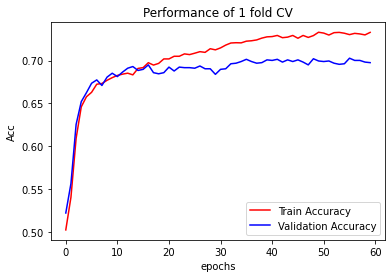

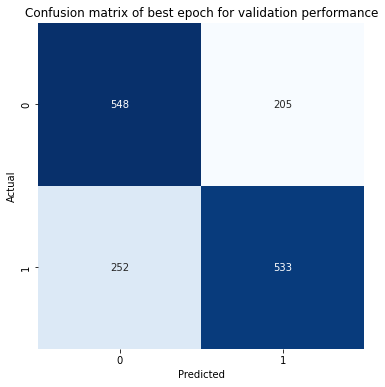

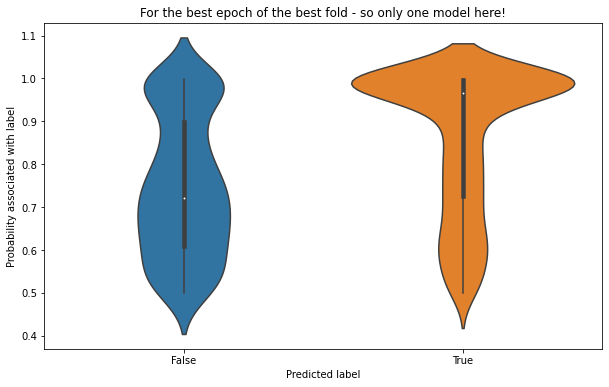

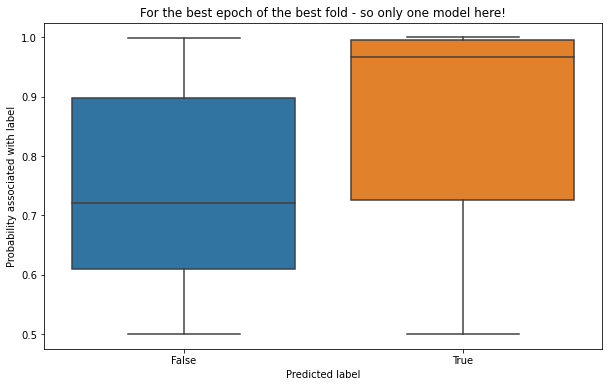

0



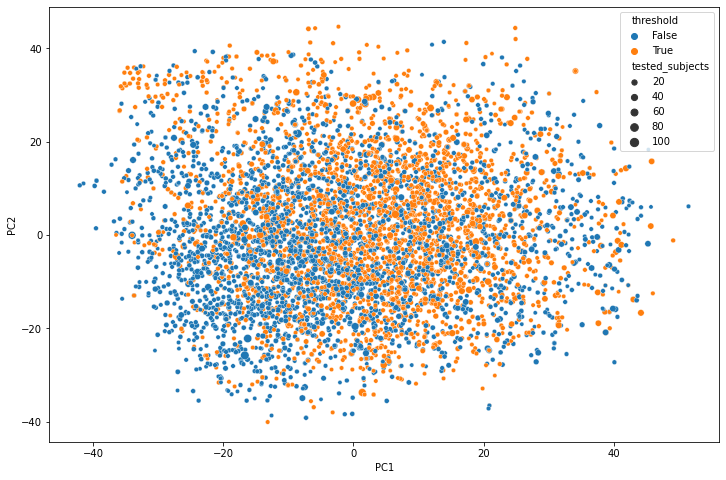

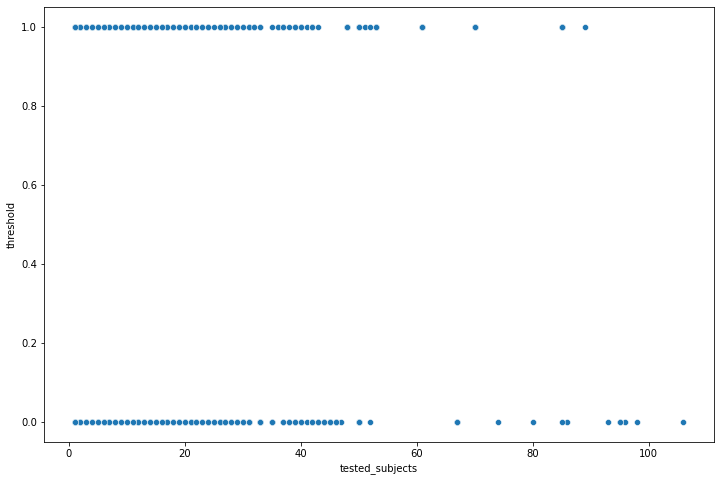

In [11]:
N = len(all_data)
K = 5
burn_in_epochs = 60
train_epochs = 100

testing = False
part_dict = {0:[0,1], 1:[2,3], 2:[4,5], 3:[6,7], 4:[8,9]}
part_dict_testing = {0:[1,2], 1:[3,4], 2:[5,6], 3:[7,8], 4:[9]}
partitions = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

lst_train_accuracies = []

lst_val_accuracies = []
lst_val_predictions = []
lst_val_labels = []
lst_val_probabilities = []

lst_test_accuracies = []
lst_test_predictions = []
lst_test_labels = []
lst_test_probabilities = []

for i in range(K):
    if testing == True:
        ## The partitions to use for training, validation ##
        testing_parts = [0]
        validation_parts = part_dict_testing[i]
        training_parts = [j for j in range(1,10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(testing_parts)]
        test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(testing_parts)]
        test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(testing_parts)]
        test_label_encoded = all_label_encoded[all_data["parts"].isin(testing_parts)]

        peptide_test = test_peptides_encoded.reshape(-1,10,12)
        HLA_test = test_HLA_encoded.reshape(-1,34,12) # 46 aligned representataion and 34 if not aligned
        binding_test = test_binding_scores_encoded.reshape(-1)
        label_test = test_label_encoded.reshape(-1)

        peptide_test_loader = list(DataLoader(peptide_test,batch_size=len(peptide_test)))
        HLA_test_loader = list(DataLoader(HLA_test,batch_size=len(peptide_test)))
        label_test_loader = list(DataLoader(label_test,batch_size=len(peptide_test)))
        binding_score_test_loader = list(DataLoader(binding_test,batch_size=len(peptide_test)))

    else:
        ## The partitions to use for training, validation ##
        validation_parts = part_dict[i]
        training_parts = [j for j in range(10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

    train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
    train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
    train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
    train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]
    train_tested_subjects = all_data[all_data["parts"].isin(training_parts)]["tested_subjects"]
    
    
    
    val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
    val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
    val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
    val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]

    ## Reshaping everything ##
    peptide_train = train_peptides_encoded.reshape(-1,10,12)
    HLA_train = train_HLA_encoded.reshape(-1,34,12)
    binding_train = train_binding_scores_encoded.reshape(-1,1)
    label_train = train_label_encoded.reshape(-1)

    peptide_val = val_peptides_encoded.reshape(-1,10,12)
    HLA_val = val_HLA_encoded.reshape(-1,34,12) # 46 aligned representataion and 34 if not aligned
    binding_val = val_binding_scores_encoded.reshape(-1,1)
    label_val = val_label_encoded.reshape(-1)


    ## Batches for training the model ##
    peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
    HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
    label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
    binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))

    peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
    HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
    label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
    binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))

    train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
    val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)

    
    net_initial = Net()
    net_initial.apply(initialize_weights)
    # Initial burn in
    burn_in_model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch= train(net_initial,device,burn_in_epochs,train_loaders,val_loaders)    
    high_confidence_train_loaders, low_confidence_train_loaders = find_low_confidence_predictions(burn_in_model,device,train_loaders,0.85)
    plot_epochs(1, [train_accuracies], [val_accuracies])
    k_fold_confusion_matrix(1, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch])
    violin_prbabilities(0, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch], [all_val_probabilities_pr_epoch])    
    plot_confidence_pca_predictions(train_loaders, burn_in_model, train_tested_subjects)
    continue

    # High confidence model
    net_high_conf = Net()
    net_high_conf.apply(initialize_weights)
    high_conf_model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch = train(net_high_conf,device,60,high_confidence_train_loaders,val_loaders)    
    plot_epochs(1, [train_accuracies], [val_accuracies])
    k_fold_confusion_matrix(1, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch])
    violin_prbabilities(0, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch], [all_val_probabilities_pr_epoch])
    
    # Low confidence model
    net_low_conf = Net()
    net_low_conf.apply(initialize_weights)
    low_conf_model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch = train(net_low_conf,device,200,low_confidence_train_loaders,val_loaders)    
    plot_epochs(1, [train_accuracies], [val_accuracies])
    k_fold_confusion_matrix(1, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch])
    violin_prbabilities(0, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch], [all_val_probabilities_pr_epoch])
    
    # lst_train_accuracies.append(train_accuracies)
    # lst_val_accuracies.append(val_accuracies)
    # lst_val_predictions.append(np.array(all_val_predictions_pr_epoch))
    # lst_val_labels.append(np.array(all_val_targets_pr_epoch))
    # lst_val_probabilities.append(np.array(all_val_probabilities_pr_epoch))
    
    # if testing == True:
        
    #     test_outputs = trained_model(peptide_test_loader[0],HLA_test_loader[0],binding_score_test_loader[0])
    #     probability,predicted_labels =  torch.max(test_outputs, 1)
    #     test_accuracies = accuracy_score(label_test,predicted_labels)
        
    #     lst_test_accuracies.append(test_accuracies)
    #     lst_test_predictions.append(predicted_labels)
    #     lst_test_labels.append(label_test)
    #     lst_test_probabilities.append(probability)



In [ ]:
def predict_using_multiple_models(models,device,valid_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    predictions_pr_model = []
    probabilities_pr_model = []

    for model in models:
        model.eval()
        with torch.no_grad():
            all_val_targets = []
            all_predicted_val_labels = []
            all_probabilities_val = []
            for j in range(len((peptide_val_loader))):
                val_peptides = peptide_val_loader[j]
                val_HLA = HLA_val_loader[j]
                val_labels = label_val_loader[j].long()
                val_binding_scores = binding_score_val_loader[j]
                outputs = model(val_peptides,val_HLA) # val_binding_scores
                probability,predicted_labels =  torch.max(outputs, 1)
                all_predicted_val_labels += predicted_labels.numpy().tolist()
                all_val_targets += val_labels.numpy().tolist()
                all_probabilities_val += probability.numpy().tolist()
        probabilities_pr_model.append(all_probabilities_val)
        predictions_pr_model.append(all_predicted_val_labels)
        
    probabilities_pr_model = np.transpose(np.array(probabilities_pr_model))
    predictions_pr_model = np.transpose(np.array(predictions_pr_model))
    predictions_using_average = [round(x,0) for x in np.mean(predictions_pr_model,axis=1)]

    accuracy = accuracy_score(predictions_using_average,np.array(all_val_targets))
    recall = recall_score(predictions_using_average,np.array(all_val_targets))
    f1 = f1_score(predictions_using_average,np.array(all_val_targets))
    print(accuracy,recall,f1)



predict_using_multiple_models([burn_in_model, high_conf_model, low_conf_model], device, val_loaders)

0.7131832797427653 0.7226074895977809 0.7002688172043011


## Statistics for network

In [ ]:
# line plot
plot_epochs(K, lst_train_accuracies, lst_val_accuracies)

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

In [ ]:
# average validation recall, accuracy and f1 for the best epoch of each fold
N = len(all_data)

if testing == True:     # The data in testing has not been used, so reduce N
    N -= len(lst_test_labels[0])

result_mtrx = calculate_avg_val_performance(K, N, lst_val_accuracies, lst_val_labels, lst_val_predictions)


Best average results - Recall: 0.6844220271065364 accuracy: 0.7244347191830781 f1-score: 0.7181589059098828


In [ ]:
# Confusion matrix for all folds (if testing == true, part 0 is not included here!)
k_fold_confusion_matrix(K, lst_val_accuracies, lst_val_labels, lst_val_predictions)


NameError: name 'k_fold_confusion_matrix' is not defined

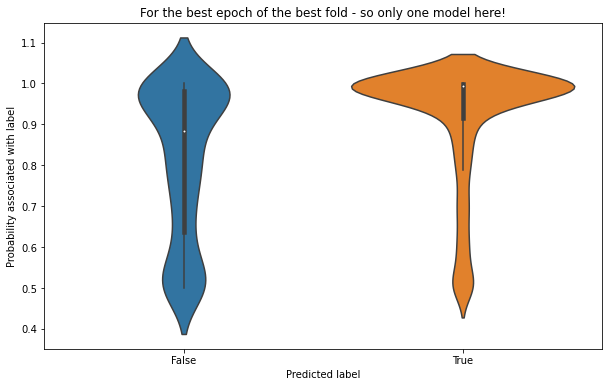

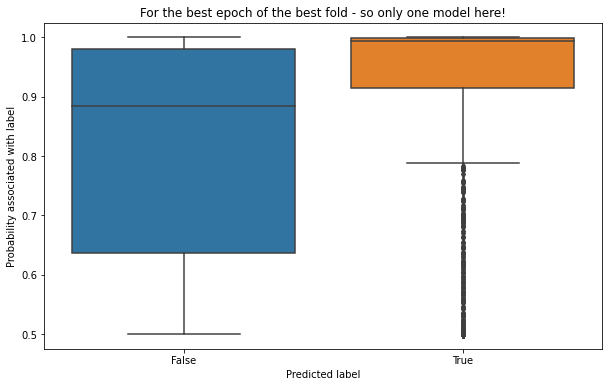

In [ ]:
# violin plot
violin_best_fold(result_mtrx, lst_val_accuracies, lst_val_labels, lst_val_predictions, lst_val_probabilities)